In [211]:
#libraries
import numpy as np
import matplotlib as plt

In [212]:
# tef,dtt,a: array [0..1501] of longint# 
# tav,ms,Ω,djs,djs1,μ,φ,Rsat,Xsp,Xsp1,PerSat,dφs,t2,t1,Jsc,Jr1,Jr2,j12,tpl1,tpl2:array [0..1500] of real# 
# t1s,t2s,te1s,te2s,Jadd1,Jadd2,k: array [1..10,0..1501] of real#
# Pp,Ps,Rp,Ap,m,Mp,φp,dφp,dt1:longint# 
# dt,n,ts,s,t:longint# 
# Rs,xp,xp1,Xplo,Xpl,Xpln,Xpln1,Xpl1o,G,Mstar,Mplanet,Ωp,F,f1,Alb:real# 
# delt,tint,i:integer# 
# delj,dttav,jav,sigmajdtt,sigmaj,sigmadtt,Jres,Jcut,Jcuto:real#
# PpObs,t0,Korr,TTVmax,TTVmin:real# 
# PerP:real#

# Jo:array [0..1500,-70000..70000] of real#
# V1,V2,V3,V4,V5,L,S3,djp1,djp,djp0:real#
# Rz,Aps,Ass:longint# 

# xs,xs1,dJ:real# 

# te1,te2:integer# 

# nn,sumn,ntav,sumtav,Delta,DeltaPp,Deltat0:real# 

In [318]:
m=1;
ms=[None]*3
a=[None]*3
Rsat=[None]*3

G=6.67*10**(-11)#
Mstar=1.99*10**30#
Mplanet=5.99*10**24#

Mp=1#{Масса планеты в относительных единицах}
ms[0]=1/81.3#{Масса спутника-1 в массах планеты}
ms[1]=1/116.14#{Масса спутника-2 в массах планеты}
ms[2]=1/98#
Ap=149598000# {Большая полуось орбиты планеты в км} 
Pp=31556952# {Период обращения планеты вокруг звезды в сек}
Ps=245000# {Период обращения спутника вокруг планеты в сек} 
Rp=6400# {Радиус планеты в км} 
Rs=695000# {Радиус звезды в км} 

a[0]=384000#{Радиус орбиты спутника-1 в км}
a[1]=192000#{Радиус орбиты спутника-2 в км}
a[2]=699000#

Rsat[0]=1738# {Радиус спутника-1 в км} 
Rsat[1]=1225# {Радиус спутника-2 в км} 
Rsat[2]=1950#
Alb=0.3#
s=1# {Число транзитов системы спутники-планета}  
tint=2000# {Время усреднения яркости до/после затмения в сек} 
delJ=0.000007#{Погрешность измения яркости, случайная добавка принимает значения от delJ до +delJ, всегда равна нулю при delt=0} 
delt=6# {Погрешность изменения времени транзита, принимает значения от -delt до +delt, в сек} 
φp=0# what is it?
Ωp=np.sqrt(G*Mstar/1000000000/Ap/Ap/Ap)#
djp=(Rp/Rs)**2#
djp0=Rp/Rs#
PerP=2*np.pi/Ωp#
Ω=[None]*m
djs=[None]*m
μ=[None]*m
dφs=[None]*m
PerSat=[None]*m
φ=[None]*m
dφs=[None]*m
t1=[None]*s   
t2=[None]*s
Xsp=[0]*m
Xspprev=[0]*m
djs1=[None]*m
tpl1=[None]*s
tpl2=[None]*s
Ω=[None]*m
w1 = s
T=70000
t1s = [[0 for x in range(m)] for y in range(w1)] 
t2s = [[0 for x in range(m)] for y in range(w1)] 
te1s = [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
te2s= [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
Jo= [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
Xpprev=0
Xplnprev=0

In [319]:
for i in range(m):
    Ω[i]=np.sqrt(G*Mplanet/1000000000/a[i]/a[i]/a[i])# {Доп. коэфф. необходим при переводе из км в метры}
    djs[i]=Rsat[i]**2/Rs**2# {Изменение яркости звезды во время транзита i-го спутника}
    μ[i]=(Mp/ms[i])# {Отношение масс i-го спутника к массе планеты.}
    print(Ω[i])
    print('djs= ', djs[i])#
    print('μ=', μ[i])#
    PerSat[i]=2*np.pi/Ω[i]#
    dφs[i]=(Ω[i]*PerP/2/np.pi-int(Ω[i]*PerP/2/np.pi))# Phase shift?
    print('Ps-',i,'=',PerSat[i])#
    print('dφs-',i,'=',dφs[i])#
    
print('Pp=',PerP)#

2.6563144917024576e-06
djs=  6.253597639873713e-06
μ= 81.3
Ps- 0 = 2365377.039054074
dφs- 0 = 0.34070305677683876
Pp= 31555792.695338428


In [215]:
djs

[6.253597639873713e-06]

In [216]:
V1=0
V2=0
V3=0
V4=0
V5=0


In [413]:
#we have to understand this loop

# print(len(Jo))

for n in range(0,s):
    #{n-transit's number}
    for i in range(m):
        φ[i]=2*np.pi*(n*dφs[i]-int(n*dφs[i]))# current phase of each satellite?
#         print(φ[i])
    
    t=-T#  
    while t<T: #by 10 second iteration

        t=t+10#
        Jo[n][int(t/10)]=1
#         dt=dt+5
        Xplo=0#
        for i in range(m):#Contribution of every satellite to planet's position
            Xplo=Xplo-(a[i]/(μ[i]+1)*np.sin(Ω[i]*t+φ[i]))
        Xp=0#
        Xp=Xplo+Ap*np.sin(Ωp*t+φp)#{координата центра планеты в момент t}
#         Xp1=0#
#         Xp1=Xplo+Ap*np.sin(Ωp*(t+5)+φp)#{координата центра планеты в момент t+1}
#         print('Xp=',Xp)
#         print('Xp=',Xp)
        
        
        #every time check the condition:
        
        if (-Xpprev>Rs+Rp) and (-Xp<Rs+Rp):
            t1[n]=t# {Условие вступления центра планеты на диск звезды, t1[n]-время начала n-го транзита в сек}
        if (Xpprev<Rs+Rp) and (Xp>Rs+Rp):
            t2[n]=t# {Условие схода центра планеты с диска звезды, t2[n]-время окончания n-го транзита в сек}
        Xpprev=Xp
        
#{Транзиты планеты без участия спутников}
        Xpln=Ap*np.sin(Ωp*t+φp)
        Xpln1=Ap*np.sin(Ωp*(t+1)+φp)#
        
        if (-Xplnprev>Rs+Rp) and (-Xpln<Rs+Rp):
            tpl1[n]=t# {Условие вступления центра планеты на диск звезды, tpl1[n]-время начала n-го транзита в сек}
        if (Xpln<Rs+Rp) and (Xpln1>Rs+Rp):
            tpl2[n]=t# {Условие схода центра планеты с диска звезды, tpl2[n]-время окончания n-го транзита в сек} 
        Xplnprev=Xpln  
#         print(Xpln, 't=',t)

        
        for i in range(m):
            Xspprev[i]=Xsp[i]
            Xsp[i]=Xp+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*t+φ[i])# {координата центра спутника в момент t}
#             print('Xspprev=',Xspprev[i],'t=',t)
#             Xsp1[i]=Xp1+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*(t+1)+φ[i])# {координата центра спутника в момент t+1}
            if (-Xspprev[i]>Rs) and (-Xsp[i]<Rs):
                t1s[n][i]=t # {Условие вступления центра спутника на диск звезды, t1s[n]-время начала n-го транзита в сек} 
#                 print('t=',t)
            if (Xspprev[i]<Rs) and (Xsp[i]>Rs):
                t2s[n][i]=t# {Условие схода центра спутника с диска звезды, t2[n]-время окончания n-го транзита в сек}
#                 print('t=',t)
            print('Xsp=',Xsp)

        for i in range(m):
            l=0
            S3=0
            v3=0 # what is it?
            v1=0
            v2=0
            if (abs(Xsp[i])<(Rs+Rsat[i])) and (abs(Xsp[i])>Rs):
                v1=1
            else:
                v1=0
                
            if  (abs(Xsp[i])>(Rs-Rsat[i])) and (abs(Xsp[i])<Rs):
                v2=1 
            else:
                v2=0
            if abs(Xsp[i])<(Rs-Rsat[i]):
                v3=1
            else:
                v3=0
                
            if v1>0 or v2>0:
#                 print('Xsp[i]=', Xsp[i])
                l=np.sqrt(Rsat[i]**2-(abs(Xsp[i])-Rs)**2)
                S3=np.arccos(abs(-Rs+abs(Xsp[i]))/Rsat[i])*Rsat[i]*Rsat[i]-l*abs(-Rs+abs(Xsp[i]))
                djs1[i]=S3/(np.pi*Rs*Rs)*50
                print(djs1[i])
#             Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs1[i]*v1-(djs[i]-djs1[i])*v2-djs[i]*v3#
            Jo[n][int(t/10)]=Jo[n][int(t/10)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xsp[i]))*(abs(Xsp[i]))/Rs/Rs)))*(djs1[i]*v1+(djs[i]-djs1[i])*v2+djs[i]*v3)               

            
        v3=0 # what is it?
        v1=0
        v2=0
        if (abs(Xp)<(Rs+Rp)) and (abs(Xp)>Rs):
            v1=1
        else:
            v1=0 
        if  (abs(Xp)>(Rs-Rp)) and (abs(Xp)<Rs):
            v2=1 
        else:
            v2=0
        if (abs(Xp)<(Rs-Rp)):
            v3=1
        else:
            v3=0
        l=0
        S3=0
        if v1>0 or v2>0:
            print('t=',t)
#             print('Xp=', Xp)
#             l=abs(abs(Xp)-Rs)
            print('l=',l)
#             S3=1/2*(Rp**2)*np.arcsin(2*l*np.sqrt(Rp**2-l**2)/Rp**2)-l*np.sqrt(Rp**2-l**2)
            l=np.sqrt(Rp**2-(abs(Xp)-Rs)**2)
            S3=np.arccos(abs(-Rs+abs(Xp))/Rp)*Rp*Rp-l*abs(-Rs+abs(Xp))#
            djp1=S3/(np.pi*Rs*Rs)
#             Jo[n][int(t/10)]=1-djp1*v1-(djp-djp1)*v2#
#         if v3>0:
#             Jo[n][int(t/10)]=1-djp*v3
        Jo[n][int(t/10)]=Jo[n][int(t/10)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*v1+(djp-djp1)*v2+djp*v3)


#             djp1=(S3/(np.pi*Rs*Rs))#
            
#         Jo[n][t]=Jo[n][t]-(djp1*(V1+V5)+(djp-djp1)*(V2+V4)+djp*V3)#
#          {Jo[n,t]=Jo[n,t]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*(V1)+(djp-djp1)*(V2)+djp*V3)#}

    print(t1[n])
    print(t2[n])
print(t1s)
print(t2s)

#     for i in range(m):
#         te1s[n][i]=t1[n]-t1s[n][i]#{Продолж. нахождения спутников на диске звезды до и после транзита планеты}
#         te2s[n][i]=t2s[n][i]-t2[n]#

Xsp= [-2153979.7115521505]
Xsp= [-2153672.0897245244]
Xsp= [-2153364.4678397747]
Xsp= [-2153056.845897909]
Xsp= [-2152749.2238989347]
Xsp= [-2152441.6018428607]
Xsp= [-2152133.979729695]
Xsp= [-2151826.3575594453]
Xsp= [-2151518.7353321197]
Xsp= [-2151211.1130477274]
Xsp= [-2150903.4907062748]
Xsp= [-2150595.868307771]
Xsp= [-2150288.245852224]
Xsp= [-2149980.623339641]
Xsp= [-2149673.000770032]
Xsp= [-2149365.378143403]
Xsp= [-2149057.7554597636]
Xsp= [-2148750.132719121]
Xsp= [-2148442.5099214837]
Xsp= [-2148134.8870668593]
Xsp= [-2147827.2641552566]
Xsp= [-2147519.641186683]
Xsp= [-2147212.018161147]
Xsp= [-2146904.3950786567]
Xsp= [-2146596.77193922]
Xsp= [-2146289.1487428453]
Xsp= [-2145981.52548954]
Xsp= [-2145673.9021793124]
Xsp= [-2145366.2788121714]
Xsp= [-2145058.6553881243]
Xsp= [-2144751.031907179]
Xsp= [-2144443.408369344]
Xsp= [-2144135.7847746275]
Xsp= [-2143828.1611230373]
Xsp= [-2143520.537414582]
Xsp= [-2143212.913649269]
Xsp= [-2142905.2898271065]
Xsp= [-2142597.6659

Xsp= [-1990317.0324881317]
Xsp= [-1990009.381412883]
Xsp= [-1989701.7302848143]
Xsp= [-1989394.0791039343]
Xsp= [-1989086.4278702508]
Xsp= [-1988778.7765837717]
Xsp= [-1988471.1252445057]
Xsp= [-1988163.4738524603]
Xsp= [-1987855.822407644]
Xsp= [-1987548.1709100648]
Xsp= [-1987240.5193597306]
Xsp= [-1986932.8677566494]
Xsp= [-1986625.2161008297]
Xsp= [-1986317.56439228]
Xsp= [-1986009.9126310074]
Xsp= [-1985702.2608170202]
Xsp= [-1985394.6089503272]
Xsp= [-1985086.957030936]
Xsp= [-1984779.3050588546]
Xsp= [-1984471.653034091]
Xsp= [-1984164.000956654]
Xsp= [-1983856.348826551]
Xsp= [-1983548.6966437907]
Xsp= [-1983241.0444083808]
Xsp= [-1982933.3921203292]
Xsp= [-1982625.7397796442]
Xsp= [-1982318.0873863343]
Xsp= [-1982010.4349404068]
Xsp= [-1981702.7824418705]
Xsp= [-1981395.1298907334]
Xsp= [-1981087.4772870033]
Xsp= [-1980779.8246306886]
Xsp= [-1980472.171921797]
Xsp= [-1980164.5191603373]
Xsp= [-1979856.8663463169]
Xsp= [-1979549.2134797443]
Xsp= [-1979241.5605606271]
Xsp= [-197

Xsp= [-1783564.0095236124]
Xsp= [-1783256.3247813024]
Xsp= [-1782948.639991623]
Xsp= [-1782640.9551545817]
Xsp= [-1782333.2702701876]
Xsp= [-1782025.5853384477]
Xsp= [-1781717.9003593714]
Xsp= [-1781410.2153329658]
Xsp= [-1781102.5302592395]
Xsp= [-1780794.8451382003]
Xsp= [-1780487.1599698567]
Xsp= [-1780179.4747542166]
Xsp= [-1779871.789491288]
Xsp= [-1779564.1041810794]
Xsp= [-1779256.4188235987]
Xsp= [-1778948.7334188537]
Xsp= [-1778641.047966853]
Xsp= [-1778333.3624676047]
Xsp= [-1778025.676921117]
Xsp= [-1777717.9913273973]
Xsp= [-1777410.3056864543]
Xsp= [-1777102.6199982963]
Xsp= [-1776794.9342629306]
Xsp= [-1776487.2484803665]
Xsp= [-1776179.5626506114]
Xsp= [-1775871.8767736736]
Xsp= [-1775564.1908495605]
Xsp= [-1775256.5048782816]
Xsp= [-1774948.8188598438]
Xsp= [-1774641.1327942559]
Xsp= [-1774333.446681526]
Xsp= [-1774025.7605216617]
Xsp= [-1773718.0743146718]
Xsp= [-1773410.3880605642]
Xsp= [-1773102.7017593463]
Xsp= [-1772795.0154110272]
Xsp= [-1772487.3290156152]
Xsp= [

Xsp= [-1590944.424760569]
Xsp= [-1590636.7119545818]
Xsp= [-1590328.9991063136]
Xsp= [-1590021.2862157724]
Xsp= [-1589713.573282967]
Xsp= [-1589405.860307905]
Xsp= [-1589098.1472905946]
Xsp= [-1588790.4342310443]
Xsp= [-1588482.7211292614]
Xsp= [-1588175.0079852552]
Xsp= [-1587867.294799033]
Xsp= [-1587559.581570603]
Xsp= [-1587251.868299974]
Xsp= [-1586944.1549871527]
Xsp= [-1586636.441632149]
Xsp= [-1586328.72823497]
Xsp= [-1586021.0147956242]
Xsp= [-1585713.3013141192]
Xsp= [-1585405.587790464]
Xsp= [-1585097.874224666]
Xsp= [-1584790.1606167338]
Xsp= [-1584482.446966675]
Xsp= [-1584174.733274499]
Xsp= [-1583867.019540212]
Xsp= [-1583559.3057638234]
Xsp= [-1583251.5919453413]
Xsp= [-1582943.878084774]
Xsp= [-1582636.1641821284]
Xsp= [-1582328.4502374143]
Xsp= [-1582020.7362506385]
Xsp= [-1581713.02222181]
Xsp= [-1581405.3081509366]
Xsp= [-1581097.5940380262]
Xsp= [-1580789.8798830872]
Xsp= [-1580482.165686128]
Xsp= [-1580174.4514471565]
Xsp= [-1579866.7371661805]
Xsp= [-1579559.0228

Xsp= [-1468779.2014982281]
Xsp= [-1468471.4725466324]
Xsp= [-1468163.743555987]
Xsp= [-1467856.0145263025]
Xsp= [-1467548.2854575852]
Xsp= [-1467240.5563498442]
Xsp= [-1466932.8272030873]
Xsp= [-1466625.0980173226]
Xsp= [-1466317.3687925586]
Xsp= [-1466009.639528803]
Xsp= [-1465701.9102260645]
Xsp= [-1465394.1808843506]
Xsp= [-1465086.4515036694]
Xsp= [-1464778.7220840298]
Xsp= [-1464470.9926254398]
Xsp= [-1464163.2631279067]
Xsp= [-1463855.5335914397]
Xsp= [-1463547.8040160462]
Xsp= [-1463240.0744017346]
Xsp= [-1462932.344748513]
Xsp= [-1462624.61505639]
Xsp= [-1462316.885325373]
Xsp= [-1462009.1555554708]
Xsp= [-1461701.425746691]
Xsp= [-1461393.695899042]
Xsp= [-1461085.9660125324]
Xsp= [-1460778.2360871693]
Xsp= [-1460470.5061229619]
Xsp= [-1460162.7761199176]
Xsp= [-1459855.0460780454]
Xsp= [-1459547.3159973524]
Xsp= [-1459239.5858778474]
Xsp= [-1458931.855719538]
Xsp= [-1458624.125522433]
Xsp= [-1458316.3952865407]
Xsp= [-1458008.6650118686]
Xsp= [-1457700.9346984248]
Xsp= [-1457

Xsp= [-1329374.1141539107]
Xsp= [-1329066.3683478022]
Xsp= [-1328758.6225063384]
Xsp= [-1328450.876629527]
Xsp= [-1328143.1307173765]
Xsp= [-1327835.384769895]
Xsp= [-1327527.6387870905]
Xsp= [-1327219.8927689714]
Xsp= [-1326912.1467155453]
Xsp= [-1326604.4006268214]
Xsp= [-1326296.6545028067]
Xsp= [-1325988.9083435105]
Xsp= [-1325681.16214894]
Xsp= [-1325373.415919104]
Xsp= [-1325065.66965401]
Xsp= [-1324757.9233536667]
Xsp= [-1324450.177018082]
Xsp= [-1324142.4306472642]
Xsp= [-1323834.6842412215]
Xsp= [-1323526.937799962]
Xsp= [-1323219.1913234936]
Xsp= [-1322911.444811825]
Xsp= [-1322603.698264964]
Xsp= [-1322295.9516829185]
Xsp= [-1321988.2050656972]
Xsp= [-1321680.4584133078]
Xsp= [-1321372.7117257589]
Xsp= [-1321064.9650030583]
Xsp= [-1320757.2182452145]
Xsp= [-1320449.471452235]
Xsp= [-1320141.724624129]
Xsp= [-1319833.9777609028]
Xsp= [-1319526.230862567]
Xsp= [-1319218.4839291286]
Xsp= [-1318910.7369605952]
Xsp= [-1318602.989956976]
Xsp= [-1318295.242918278]
Xsp= [-1317987.49

Xsp= [-1174881.4445134439]
Xsp= [-1174573.6819850767]
Xsp= [-1174265.9194254517]
Xsp= [-1173958.1568345763]
Xsp= [-1173650.3942124594]
Xsp= [-1173342.6315591093]
Xsp= [-1173034.8688745336]
Xsp= [-1172727.1061587406]
Xsp= [-1172419.3434117388]
Xsp= [-1172111.5806335357]
Xsp= [-1171803.8178241404]
Xsp= [-1171496.0549835605]
Xsp= [-1171188.2921118042]
Xsp= [-1170880.5292088797]
Xsp= [-1170572.7662747954]
Xsp= [-1170265.0033095588]
Xsp= [-1169957.2403131786]
Xsp= [-1169649.4772856631]
Xsp= [-1169341.7142270203]
Xsp= [-1169033.951137258]
Xsp= [-1168726.188016385]
Xsp= [-1168418.4248644088]
Xsp= [-1168110.6616813382]
Xsp= [-1167802.898467181]
Xsp= [-1167495.1352219456]
Xsp= [-1167187.3719456396]
Xsp= [-1166879.6086382722]
Xsp= [-1166571.8452998507]
Xsp= [-1166264.0819303833]
Xsp= [-1165956.3185298787]
Xsp= [-1165648.5550983446]
Xsp= [-1165340.7916357894]
Xsp= [-1165033.028142221]
Xsp= [-1164725.264617648]
Xsp= [-1164417.5010620784]
Xsp= [-1164109.7374755198]
Xsp= [-1163801.9738579814]
Xsp= [

Xsp= [-1014840.902153804]
Xsp= [-1014533.1244737778]
Xsp= [-1014225.3467667433]
Xsp= [-1013917.5690327083]
Xsp= [-1013609.7912716811]
Xsp= [-1013302.0134836697]
Xsp= [-1012994.2356686823]
Xsp= [-1012686.4578267274]
Xsp= [-1012378.6799578128]
Xsp= [-1012070.9020619469]
Xsp= [-1011763.1241391377]
Xsp= [-1011455.3461893935]
Xsp= [-1011147.5682127224]
Xsp= [-1010839.7902091327]
Xsp= [-1010532.0121786327]
Xsp= [-1010224.2341212301]
Xsp= [-1009916.4560369335]
Xsp= [-1009608.6779257507]
Xsp= [-1009300.8997876903]
Xsp= [-1008993.1216227601]
Xsp= [-1008685.3434309687]
Xsp= [-1008377.5652123239]
Xsp= [-1008069.7869668342]
Xsp= [-1007762.0086945075]
Xsp= [-1007454.2303953519]
Xsp= [-1007146.4520693759]
Xsp= [-1006838.6737165875]
Xsp= [-1006530.8953369948]
Xsp= [-1006223.1169306061]
Xsp= [-1005915.3384974299]
Xsp= [-1005607.5600374736]
Xsp= [-1005299.781550746]
Xsp= [-1004992.003037255]
Xsp= [-1004684.2244970088]
Xsp= [-1004376.4459300159]
Xsp= [-1004068.667336284]
Xsp= [-1003760.8887158216]
Xsp= 

Xsp= [-848945.0288743777]
Xsp= [-848637.2378226218]
Xsp= [-848329.4467482667]
Xsp= [-848021.6556513206]
Xsp= [-847713.8645317915]
Xsp= [-847406.0733896876]
Xsp= [-847098.2822250172]
Xsp= [-846790.4910377886]
Xsp= [-846482.6998280096]
Xsp= [-846174.9085956888]
Xsp= [-845867.117340834]
Xsp= [-845559.3260634537]
Xsp= [-845251.5347635559]
Xsp= [-844943.7434411489]
Xsp= [-844635.9520962408]
Xsp= [-844328.1607288398]
Xsp= [-844020.369338954]
Xsp= [-843712.5779265917]
Xsp= [-843404.7864917613]
Xsp= [-843096.9950344705]
Xsp= [-842789.203554728]
Xsp= [-842481.4120525415]
Xsp= [-842173.6205279196]
Xsp= [-841865.8289808702]
Xsp= [-841558.0374114015]
Xsp= [-841250.2458195217]
Xsp= [-840942.4542052393]
Xsp= [-840634.662568562]
Xsp= [-840326.8709094983]
Xsp= [-840019.0792280562]
Xsp= [-839711.2875242442]
Xsp= [-839403.49579807]
Xsp= [-839095.7040495423]
Xsp= [-838787.912278669]
Xsp= [-838480.120485458]
Xsp= [-838172.3286699184]
Xsp= [-837864.5368320573]
Xsp= [-837556.7449718835]
Xsp= [-837248.953089

Xsp= [-673192.9133025076]
Xsp= [-672885.1106788648]
Xsp= [-672577.3080372981]
Xsp= [-672269.505377816]
Xsp= [-671961.7027004261]
Xsp= [-671653.9000051371]
Xsp= [-671346.0972919569]
Xsp= [-671038.2945608938]
Xsp= [-670730.491811956]
Xsp= [-670422.6890451517]
Xsp= [-670114.8862604891]
Xsp= [-669807.0834579763]
Xsp= [-669499.2806376215]
Xsp= [-669191.4777994332]
Xsp= [-668883.674943419]
Xsp= [-668575.8720695876]
Xsp= [-668268.069177947]
Xsp= [-667960.2662685055]
Xsp= [-667652.4633412709]
Xsp= [-667344.6603962518]
Xsp= [-667036.8574334566]
Xsp= [-666729.054452893]
Xsp= [-666421.2514545694]
Xsp= [-666113.4484384937]
Xsp= [-665805.6454046746]
Xsp= [-665497.84235312]
Xsp= [-665190.039283838]
Xsp= [-664882.236196837]
Xsp= [-664574.4330921252]
Xsp= [-664266.6299697108]
Xsp= [-663958.8268296017]
Xsp= [-663651.0236718064]
Xsp= [-663343.2204963329]
Xsp= [-663035.4173031895]
Xsp= [-662727.6140923845]
Xsp= [-662419.8108639257]
Xsp= [-662112.0076178218]
Xsp= [-661804.2043540806]
Xsp= [-661496.4010727

Xsp= [-544222.1441086037]
Xsp= [-543914.334692325]
Xsp= [-543606.5252615557]
Xsp= [-543298.7158163039]
Xsp= [-542990.9063565774]
Xsp= [-542683.0968823849]
Xsp= [-542375.2873937347]
Xsp= [-542067.4778906344]
Xsp= [-541759.6683730928]
Xsp= [-541451.8588411177]
Xsp= [-541144.0492947174]
Xsp= [-540836.2397339002]
Xsp= [-540528.430158674]
Xsp= [-540220.6205690475]
Xsp= [-539912.8109650285]
Xsp= [-539605.0013466253]
Xsp= [-539297.191713846]
Xsp= [-538989.3820666991]
Xsp= [-538681.5724051924]
Xsp= [-538373.7627293344]
Xsp= [-538065.9530391332]
Xsp= [-537758.1433345969]
Xsp= [-537450.3336157338]
Xsp= [-537142.523882552]
Xsp= [-536834.7141350599]
Xsp= [-536526.9043732655]
Xsp= [-536219.0945971771]
Xsp= [-535911.2848068028]
Xsp= [-535603.4750021509]
Xsp= [-535295.6651832295]
Xsp= [-534987.8553500469]
Xsp= [-534680.0455026112]
Xsp= [-534372.2356409306]
Xsp= [-534064.4257650133]
Xsp= [-533756.6158748677]
Xsp= [-533448.8059705016]
Xsp= [-533140.9960519236]
Xsp= [-532833.1861191416]
Xsp= [-532525.37

Xsp= [-331830.6492032791]
Xsp= [-331522.831736957]
Xsp= [-331215.014261801]
Xsp= [-330907.1967778192]
Xsp= [-330599.37928501994]
Xsp= [-330291.5617834112]
Xsp= [-329983.7442730013]
Xsp= [-329675.9267537984]
Xsp= [-329368.10922581085]
Xsp= [-329060.2916890468]
Xsp= [-328752.47414351424]
Xsp= [-328444.65658922156]
Xsp= [-328136.8390261769]
Xsp= [-327829.02145438857]
Xsp= [-327521.20387386467]
Xsp= [-327213.38628461334]
Xsp= [-326905.56868664286]
Xsp= [-326597.7510799615]
Xsp= [-326289.9334645773]
Xsp= [-325982.1158404986]
Xsp= [-325674.29820773355]
Xsp= [-325366.4805662903]
Xsp= [-325058.6629161771]
Xsp= [-324750.8452574022]
Xsp= [-324443.02758997376]
Xsp= [-324135.20991389995]
Xsp= [-323827.39222918893]
Xsp= [-323519.57453584904]
Xsp= [-323211.7568338883]
Xsp= [-322903.9391233151]
Xsp= [-322596.12140413746]
Xsp= [-322288.3036763638]
Xsp= [-321980.48594000214]
Xsp= [-321672.6681950607]
Xsp= [-321364.8504415478]
Xsp= [-321057.0326794715]
Xsp= [-320749.2149088401]
Xsp= [-320441.39712966164

Xsp= [-172995.8495106389]
Xsp= [-172688.02857569483]
Xsp= [-172380.2076361488]
Xsp= [-172072.38669200905]
Xsp= [-171764.5657432838]
Xsp= [-171456.74478998125]
Xsp= [-171148.9238321096]
Xsp= [-170841.10286967698]
Xsp= [-170533.2819026917]
Xsp= [-170225.46093116188]
Xsp= [-169917.63995509577]
Xsp= [-169609.81897450154]
Xsp= [-169301.99798938737]
Xsp= [-168994.17699976155]
Xsp= [-168686.3560056322]
Xsp= [-168378.5350070076]
Xsp= [-168070.71400389588]
Xsp= [-167762.8929963053]
Xsp= [-167455.071984244]
Xsp= [-167147.25096772026]
Xsp= [-166839.4299467422]
Xsp= [-166531.6089213181]
Xsp= [-166223.7878914561]
Xsp= [-165915.96685716446]
Xsp= [-165608.1458184513]
Xsp= [-165300.3247753249]
Xsp= [-164992.50372779334]
Xsp= [-164684.68267586504]
Xsp= [-164376.86161954806]
Xsp= [-164069.04055885063]
Xsp= [-163761.2194937809]
Xsp= [-163453.39842434714]
Xsp= [-163145.57735055758]
Xsp= [-162837.7562724203]
Xsp= [-162529.93518994364]
Xsp= [-162222.1141031357]
Xsp= [-161914.2930120047]
Xsp= [-161606.471916

Xsp= [-8619.022356992446]
Xsp= [-8311.200131987329]
Xsp= [-8003.37790676072]
Xsp= [-7695.555681320824]
Xsp= [-7387.733455675846]
Xsp= [-7079.911229833986]
Xsp= [-6772.08900380345]
Xsp= [-6464.266777592442]
Xsp= [-6156.444551209162]
Xsp= [-5848.6223246618165]
Xsp= [-5540.800097958608]
Xsp= [-5232.977871107739]
Xsp= [-4925.1556441174125]
Xsp= [-4617.3334169958325]
Xsp= [-4309.511189751202]
Xsp= [-4001.6889623917264]
Xsp= [-3693.8667349256066]
Xsp= [-3386.0445073610467]
Xsp= [-3078.2222797062504]
Xsp= [-2770.400051969421]
Xsp= [-2462.5778241587604]
Xsp= [-2154.7555962824736]
Xsp= [-1846.9333683487641]
Xsp= [-1539.111140365834]
Xsp= [-1231.288912341887]
Xsp= [-923.466684285127]
Xsp= [-615.6444562037569]
Xsp= [-307.8222281059801]
Xsp= [0.0]
Xsp= [307.8222281059801]
Xsp= [615.6444562037569]
Xsp= [923.466684285127]
Xsp= [1231.288912341887]
Xsp= [1539.111140365834]
Xsp= [1846.9333683487641]
Xsp= [2154.7555962824736]
Xsp= [2462.5778241587604]
Xsp= [2770.400051969421]
Xsp= [3078.2222797062504]
X

Xsp= [216706.37155191827]
Xsp= [217014.19174433473]
Xsp= [217322.01193096818]
Xsp= [217629.8321118103]
Xsp= [217937.6522868529]
Xsp= [218245.4724560879]
Xsp= [218553.2926195071]
Xsp= [218861.1127771021]
Xsp= [219168.93292886484]
Xsp= [219476.75307478715]
Xsp= [219784.57321486078]
Xsp= [220092.3933490775]
Xsp= [220400.21347742915]
Xsp= [220708.03359990756]
Xsp= [221015.8537165044]
Xsp= [221323.67382721155]
Xsp= [221631.49393202088]
Xsp= [221939.31403092403]
Xsp= [222247.13412391295]
Xsp= [222554.95421097934]
Xsp= [222862.77429211503]
Xsp= [223170.5943673118]
Xsp= [223478.4144365615]
Xsp= [223786.23449985587]
Xsp= [224094.05455718673]
Xsp= [224401.87460854594]
Xsp= [224709.6946539252]
Xsp= [225017.5146933163]
Xsp= [225325.3347267111]
Xsp= [225633.1547541014]
Xsp= [225940.97477547897]
Xsp= [226248.7947908356]
Xsp= [226556.61480016314]
Xsp= [226864.4348034533]
Xsp= [227172.25480069796]
Xsp= [227480.07479188894]
Xsp= [227787.8947770179]
Xsp= [228095.7147560768]
Xsp= [228403.53472905734]
Xsp

Xsp= [375232.8196047952]
Xsp= [375540.6357334379]
Xsp= [375848.45185207395]
Xsp= [376156.26796069543]
Xsp= [376464.08405929385]
Xsp= [376771.9001478611]
Xsp= [377079.7162263889]
Xsp= [377387.5322948692]
Xsp= [377695.3483532938]
Xsp= [378003.1644016543]
Xsp= [378310.98043994274]
Xsp= [378618.79646815074]
Xsp= [378926.6124862702]
Xsp= [379234.42849429295]
Xsp= [379542.2444922106]
Xsp= [379850.0604800151]
Xsp= [380157.87645769835]
Xsp= [380465.692425252]
Xsp= [380773.50838266785]
Xsp= [381081.32432993775]
Xsp= [381389.1402670534]
Xsp= [381696.9561940068]
Xsp= [382004.7721107897]
Xsp= [382312.5880173937]
Xsp= [382620.4039138108]
Xsp= [382928.2198000327]
Xsp= [383236.0356760513]
Xsp= [383543.8515418582]
Xsp= [383851.6673974455]
Xsp= [384159.4832428047]
Xsp= [384467.29907792783]
Xsp= [384775.11490280664]
Xsp= [385082.9307174328]
Xsp= [385390.74652179825]
Xsp= [385698.56231589464]
Xsp= [386006.378099714]
Xsp= [386314.19387324795]
Xsp= [386622.0096364884]
Xsp= [386929.825389427]
Xsp= [387237.6

Xsp= [571309.315032598]
Xsp= [571617.1231263785]
Xsp= [571924.9312049309]
Xsp= [572232.7392682468]
Xsp= [572540.5473163178]
Xsp= [572848.355349136]
Xsp= [573156.1633666931]
Xsp= [573463.9713689811]
Xsp= [573771.7793559913]
Xsp= [574079.5873277159]
Xsp= [574387.395284147]
Xsp= [574695.2032252757]
Xsp= [575003.0111510943]
Xsp= [575310.8190615944]
Xsp= [575618.626956768]
Xsp= [575926.4348366064]
Xsp= [576234.2427011019]
Xsp= [576542.0505502464]
Xsp= [576849.8583840312]
Xsp= [577157.6662024485]
Xsp= [577465.47400549]
Xsp= [577773.2817931476]
Xsp= [578081.0895654128]
Xsp= [578388.8973222778]
Xsp= [578696.7050637341]
Xsp= [579004.5127897735]
Xsp= [579312.320500388]
Xsp= [579620.1281955695]
Xsp= [579927.9358753095]
Xsp= [580235.7435395999]
Xsp= [580543.5511884326]
Xsp= [580851.3588217993]
Xsp= [581159.1664396919]
Xsp= [581466.9740421022]
Xsp= [581774.7816290219]
Xsp= [582082.5892004428]
Xsp= [582390.3967563569]
Xsp= [582698.204296756]
Xsp= [583006.0118216315]
Xsp= [583313.8193309756]
Xsp= [58

Xsp= [699356.069932187]
Xsp= [699663.8709837343]
Xsp= [699971.6720166451]
Xsp= [700279.4730309113]
Xsp= [700587.2740265244]
Xsp= [700895.0750034767]
Xsp= [701202.8759617595]
Xsp= [701510.676901365]
Xsp= [701818.477822285]
Xsp= [702126.2787245109]
Xsp= [702434.079608035]
Xsp= [702741.8804728491]
Xsp= [703049.6813189444]
Xsp= [703357.4821463134]
Xsp= [703665.2829549476]
Xsp= [703973.0837448387]
Xsp= [704280.8845159789]
Xsp= [704588.6852683595]
Xsp= [704896.4860019727]
Xsp= [705204.2867168101]
Xsp= [705512.0874128637]
Xsp= [705819.888090125]
Xsp= [706127.6887485861]
Xsp= [706435.4893882389]
Xsp= [706743.290009075]
Xsp= [707051.0906110859]
Xsp= [707358.8911942642]
Xsp= [707666.6917586009]
Xsp= [707974.4923040882]
Xsp= [708282.292830718]
Xsp= [708590.093338482]
Xsp= [708897.893827372]
Xsp= [709205.6942973797]
Xsp= [709513.4947484971]
Xsp= [709821.295180716]
Xsp= [710129.095594028]
Xsp= [710436.8959884252]
Xsp= [710744.696363899]
Xsp= [711052.4967204416]
Xsp= [711360.2970580447]
Xsp= [711668

Xsp= [866796.8709287695]
Xsp= [867104.6606326812]
Xsp= [867412.4503135029]
Xsp= [867720.239971226]
Xsp= [868028.0296058423]
Xsp= [868335.8192173439]
Xsp= [868643.6088057222]
Xsp= [868951.3983709693]
Xsp= [869259.187913077]
Xsp= [869566.977432037]
Xsp= [869874.7669278412]
Xsp= [870182.5564004816]
Xsp= [870490.3458499496]
Xsp= [870798.1352762375]
Xsp= [871105.9246793368]
Xsp= [871413.7140592394]
Xsp= [871721.5034159371]
Xsp= [872029.2927494216]
Xsp= [872337.0820596848]
Xsp= [872644.8713467186]
Xsp= [872952.6606105148]
Xsp= [873260.4498510651]
Xsp= [873568.2390683615]
Xsp= [873876.0282623956]
Xsp= [874183.8174331596]
Xsp= [874491.6065806447]
Xsp= [874799.3957048432]
Xsp= [875107.1848057469]
Xsp= [875414.9738833476]
Xsp= [875722.7629376367]
Xsp= [876030.5519686064]
Xsp= [876338.3409762486]
Xsp= [876646.1299605549]
Xsp= [876953.9189215171]
Xsp= [877261.7078591272]
Xsp= [877569.4967733768]
Xsp= [877877.285664258]
Xsp= [878185.0745317623]
Xsp= [878492.8633758817]
Xsp= [878800.652196608]
Xsp= 

Xsp= [1021304.2271808789]
Xsp= [1021612.0042646468]
Xsp= [1021919.7813212179]
Xsp= [1022227.5583505841]
Xsp= [1022535.3353527373]
Xsp= [1022843.1123276695]
Xsp= [1023150.8892753721]
Xsp= [1023458.6661958373]
Xsp= [1023766.4430890569]
Xsp= [1024074.2199550223]
Xsp= [1024381.9967937258]
Xsp= [1024689.773605159]
Xsp= [1024997.5503893137]
Xsp= [1025305.327146182]
Xsp= [1025613.1038757553]
Xsp= [1025920.8805780257]
Xsp= [1026228.657252985]
Xsp= [1026536.433900625]
Xsp= [1026844.2105209376]
Xsp= [1027151.9871139143]
Xsp= [1027459.7636795475]
Xsp= [1027767.5402178285]
Xsp= [1028075.3167287493]
Xsp= [1028383.0932123017]
Xsp= [1028690.8696684776]
Xsp= [1028998.6460972688]
Xsp= [1029306.422498667]
Xsp= [1029614.1988726644]
Xsp= [1029921.9752192523]
Xsp= [1030229.7515384229]
Xsp= [1030537.527830168]
Xsp= [1030845.3040944792]
Xsp= [1031153.0803313486]
Xsp= [1031460.8565407677]
Xsp= [1031768.6327227287]
Xsp= [1032076.408877223]
Xsp= [1032384.1850042428]
Xsp= [1032691.9611037796]
Xsp= [1032999.73717

Xsp= [1181652.212212711]
Xsp= [1181959.9740198893]
Xsp= [1182267.7357956138]
Xsp= [1182575.4975398758]
Xsp= [1182883.259252668]
Xsp= [1183191.0209339808]
Xsp= [1183498.7825838076]
Xsp= [1183806.5442021391]
Xsp= [1184114.3057889678]
Xsp= [1184422.0673442853]
Xsp= [1184729.8288680832]
Xsp= [1185037.590360354]
Xsp= [1185345.351821089]
Xsp= [1185653.11325028]
Xsp= [1185960.8746479189]
Xsp= [1186268.6360139973]
Xsp= [1186576.3973485075]
Xsp= [1186884.1586514413]
Xsp= [1187191.9199227907]
Xsp= [1187499.6811625469]
Xsp= [1187807.442370702]
Xsp= [1188115.2035472482]
Xsp= [1188422.9646921766]
Xsp= [1188730.72580548]
Xsp= [1189038.486887149]
Xsp= [1189346.2479371768]
Xsp= [1189654.008955554]
Xsp= [1189961.7699422736]
Xsp= [1190269.5308973263]
Xsp= [1190577.2918207047]
Xsp= [1190885.0527124004]
Xsp= [1191192.8135724056]
Xsp= [1191500.574400711]
Xsp= [1191808.3351973097]
Xsp= [1192116.0959621929]
Xsp= [1192423.8566953526]
Xsp= [1192731.6173967805]
Xsp= [1193039.3780664688]
Xsp= [1193347.1387044084

Xsp= [1313063.5379013661]
Xsp= [1313371.2855351444]
Xsp= [1313679.0331339831]
Xsp= [1313986.7806978738]
Xsp= [1314294.5282268089]
Xsp= [1314602.2757207802]
Xsp= [1314910.0231797795]
Xsp= [1315217.7706037986]
Xsp= [1315525.5179928287]
Xsp= [1315833.2653468624]
Xsp= [1316141.0126658918]
Xsp= [1316448.7599499081]
Xsp= [1316756.5071989032]
Xsp= [1317064.2544128692]
Xsp= [1317372.001591798]
Xsp= [1317679.7487356812]
Xsp= [1317987.4958445104]
Xsp= [1318295.242918278]
Xsp= [1318602.989956976]
Xsp= [1318910.7369605952]
Xsp= [1319218.4839291286]
Xsp= [1319526.230862567]
Xsp= [1319833.9777609028]
Xsp= [1320141.724624129]
Xsp= [1320449.471452235]
Xsp= [1320757.2182452145]
Xsp= [1321064.9650030583]
Xsp= [1321372.7117257589]
Xsp= [1321680.4584133078]
Xsp= [1321988.2050656972]
Xsp= [1322295.9516829185]
Xsp= [1322603.698264964]
Xsp= [1322911.444811825]
Xsp= [1323219.1913234936]
Xsp= [1323526.937799962]
Xsp= [1323834.6842412215]
Xsp= [1324142.4306472642]
Xsp= [1324450.177018082]
Xsp= [1324757.92335366

Xsp= [1463855.5335914397]
Xsp= [1464163.2631279067]
Xsp= [1464470.9926254398]
Xsp= [1464778.7220840298]
Xsp= [1465086.4515036694]
Xsp= [1465394.1808843506]
Xsp= [1465701.9102260645]
Xsp= [1466009.639528803]
Xsp= [1466317.3687925586]
Xsp= [1466625.0980173226]
Xsp= [1466932.8272030873]
Xsp= [1467240.5563498442]
Xsp= [1467548.2854575852]
Xsp= [1467856.0145263025]
Xsp= [1468163.743555987]
Xsp= [1468471.4725466324]
Xsp= [1468779.2014982281]
Xsp= [1469086.9304107681]
Xsp= [1469394.659284243]
Xsp= [1469702.388118645]
Xsp= [1470010.1169139661]
Xsp= [1470317.845670198]
Xsp= [1470625.5743873327]
Xsp= [1470933.3030653617]
Xsp= [1471241.031704277]
Xsp= [1471548.7603040708]
Xsp= [1471856.488864735]
Xsp= [1472164.2173862604]
Xsp= [1472471.9458686402]
Xsp= [1472779.6743118656]
Xsp= [1473087.402715928]
Xsp= [1473395.1310808202]
Xsp= [1473702.859406534]
Xsp= [1474010.58769306]
Xsp= [1474318.3159403917]
Xsp= [1474626.0441485199]
Xsp= [1474933.7723174368]
Xsp= [1475241.5004471343]
Xsp= [1475549.228537603

Xsp= [1666332.767908242]
Xsp= [1666640.4700659849]
Xsp= [1666948.172179438]
Xsp= [1667255.8742485926]
Xsp= [1667563.5762734415]
Xsp= [1667871.2782539758]
Xsp= [1668178.9801901877]
Xsp= [1668486.6820820689]
Xsp= [1668794.3839296114]
Xsp= [1669102.0857328072]
Xsp= [1669409.7874916478]
Xsp= [1669717.489206125]
Xsp= [1670025.190876231]
Xsp= [1670332.892501958]
Xsp= [1670640.5940832973]
Xsp= [1670948.2956202407]
Xsp= [1671255.9971127806]
Xsp= [1671563.6985609084]
Xsp= [1671871.3999646164]
Xsp= [1672179.1013238959]
Xsp= [1672486.8026387393]
Xsp= [1672794.5039091385]
Xsp= [1673102.2051350847]
Xsp= [1673409.9063165702]
Xsp= [1673717.607453587]
Xsp= [1674025.3085461268]
Xsp= [1674333.0095941818]
Xsp= [1674640.710597743]
Xsp= [1674948.4115568034]
Xsp= [1675256.1124713537]
Xsp= [1675563.813341387]
Xsp= [1675871.5141668941]
Xsp= [1676179.214947868]
Xsp= [1676486.9156842993]
Xsp= [1676794.6163761807]
Xsp= [1677102.3170235038]
Xsp= [1677410.0176262604]
Xsp= [1677717.7181844425]
Xsp= [1678025.4186980

Xsp= [1857714.6319006572]
Xsp= [1858022.3049408451]
Xsp= [1858329.9779316913]
Xsp= [1858637.6508731872]
Xsp= [1858945.3237653254]
Xsp= [1859252.9966080969]
Xsp= [1859560.6694014943]
Xsp= [1859868.342145509]
Xsp= [1860176.0148401335]
Xsp= [1860483.687485359]
Xsp= [1860791.3600811774]
Xsp= [1861099.0326275814]
Xsp= [1861406.7051245621]
Xsp= [1861714.3775721118]
Xsp= [1862022.049970222]
Xsp= [1862329.722318885]
Xsp= [1862637.3946180923]
Xsp= [1862945.0668678363]
Xsp= [1863252.7390681081]
Xsp= [1863560.4112189005]
Xsp= [1863868.0833202049]
Xsp= [1864175.7553720132]
Xsp= [1864483.4273743173]
Xsp= [1864791.0993271093]
Xsp= [1865098.7712303803]
Xsp= [1865406.4430841233]
Xsp= [1865714.1148883298]
Xsp= [1866021.7866429912]
Xsp= [1866329.4583481]
Xsp= [1866637.1300036476]
Xsp= [1866944.8016096265]
Xsp= [1867252.4731660278]
Xsp= [1867560.144672844]
Xsp= [1867867.8161300668]
Xsp= [1868175.487537688]
Xsp= [1868483.1588957]
Xsp= [1868790.8302040938]
Xsp= [1869098.501462862]
Xsp= [1869406.1726719958]

Xsp= [2006007.1670972344]
Xsp= [2006314.8154147007]
Xsp= [2006622.4636789178]
Xsp= [2006930.1118898783]
Xsp= [2007237.7600475736]
Xsp= [2007545.4081519956]
Xsp= [2007853.0562031367]
Xsp= [2008160.704200988]
Xsp= [2008468.352145542]
Xsp= [2008776.00003679]
Xsp= [2009083.6478747248]
Xsp= [2009391.295659338]
Xsp= [2009698.9433906209]
Xsp= [2010006.5910685658]
Xsp= [2010314.2386931644]
Xsp= [2010621.8862644094]
Xsp= [2010929.533782292]
Xsp= [2011237.181246804]
Xsp= [2011544.828657938]
Xsp= [2011852.476015685]
Xsp= [2012160.1233200373]
Xsp= [2012467.7705709871]
Xsp= [2012775.4177685257]
Xsp= [2013083.0649126456]
Xsp= [2013390.7120033384]
Xsp= [2013698.359040596]
Xsp= [2014006.0060244105]
Xsp= [2014313.6529547735]
Xsp= [2014621.2998316772]
Xsp= [2014928.9466551135]
Xsp= [2015236.5934250737]
Xsp= [2015544.2401415503]
Xsp= [2015851.8868045355]
Xsp= [2016159.5334140204]
Xsp= [2016467.1799699974]
Xsp= [2016774.8264724582]
Xsp= [2017082.472921395]
Xsp= [2017390.119316799]
Xsp= [2017697.765658663]

In [414]:
len(Jo[0])

14000

In [415]:
curve=[]
index=[]
k=0
for i in range(-7000,7000):
    if Jo[0][i]!=1:
        curve.append(Jo[0][i])
        index.append(k)
        k=k+1
        print('i=',i*10,Jo[0][i])

i= -23550 0.9999998677779337
i= -23540 0.9999995103391668
i= -23530 0.9999990342886327
i= -23520 0.9999984718779031
i= -23510 0.9999978415445212
i= -23500 0.999997156099922
i= -23490 0.9999964253867801
i= -23480 0.9999956574668022
i= -23470 0.9999948592549305
i= -23460 0.9999940369036181
i= -23450 0.9999931960627435
i= -23440 0.9999923420768748
i= -23430 0.9999914801566454
i= -23420 0.9999906155531573
i= -23410 0.9999897537681017
i= -23400 0.9999889008510893
i= -23390 0.9999880638865624
i= -23380 0.9999872519129376
i= -23370 0.9999864779659444
i= -23360 0.9999857648052555
i= -23350 0.9999851695961669
i= -23340 0.999984596438728
i= -23330 0.9999831426953627
i= -23320 0.9999818619047494
i= -23310 0.999980627172368
i= -23300 0.9999794155990475
i= -23290 0.9999782198294724
i= -23280 0.999977037617041
i= -23270 0.999975868988209
i= -23260 0.9999747152009419
i= -23250 0.999973578298849
i= -23240 0.9999724609098182
i= -23230 0.9999713661639709
i= -23220 0.9999702976819016
i= -23210 0.99996925

i= -19510 0.9999358257535909
i= -19500 0.9999357867452509
i= -19490 0.9999357478040585
i= -19480 0.9999357089297699
i= -19470 0.9999356701221427
i= -19460 0.9999356313809366
i= -19450 0.999935592705912
i= -19440 0.999935554096832
i= -19430 0.9999355155534603
i= -19420 0.9999354770755625
i= -19410 0.9999354386629058
i= -19400 0.9999354003152587
i= -19390 0.9999353620323916
i= -19380 0.9999353238140757
i= -19370 0.9999352856600843
i= -19360 0.9999352475701915
i= -19350 0.9999352095441737
i= -19340 0.999935171581808
i= -19330 0.9999351336828731
i= -19320 0.9999350958471495
i= -19310 0.9999350580744184
i= -19300 0.9999350203644628
i= -19290 0.9999349827170669
i= -19280 0.9999349451320166
i= -19270 0.9999349076090986
i= -19260 0.9999348701481012
i= -19250 0.9999348327488143
i= -19240 0.9999347954110286
i= -19230 0.9999347581345363
i= -19220 0.9999347209191308
i= -19210 0.999934683764607
i= -19200 0.9999346466707609
i= -19190 0.9999346096373898
i= -19180 0.9999345726642919
i= -19170 0.999934

i= -15760 0.9999245617137371
i= -15750 0.9999245383590526
i= -15740 0.9999245150316988
i= -15730 0.9999244917316313
i= -15720 0.9999244684588071
i= -15710 0.9999244452131821
i= -15700 0.9999244219947129
i= -15690 0.9999243988033564
i= -15680 0.9999243756390691
i= -15670 0.9999243525018082
i= -15660 0.9999243293915309
i= -15650 0.999924306308194
i= -15640 0.9999242832517552
i= -15630 0.9999242602221721
i= -15620 0.999924237219402
i= -15610 0.9999242142434032
i= -15600 0.9999241912941332
i= -15590 0.9999241683715503
i= -15580 0.9999241454756127
i= -15570 0.9999241226062787
i= -15560 0.9999240997635068
i= -15550 0.9999240769472556
i= -15540 0.999924054157484
i= -15530 0.9999240313941505
i= -15520 0.9999240086572145
i= -15510 0.9999239859466349
i= -15500 0.9999239632623713
i= -15490 0.9999239406043828
i= -15480 0.9999239179726291
i= -15470 0.9999238953670697
i= -15460 0.9999238727876647
i= -15450 0.9999238502343737
i= -15440 0.999923827707157
i= -15430 0.9999238052059747
i= -15420 0.999923

i= -11320 0.9999164107970328
i= -11310 0.9999163966673529
i= -11300 0.9999163825540154
i= -11290 0.999916368457007
i= -11280 0.9999163543763142
i= -11270 0.9999163403119238
i= -11260 0.9999163262638223
i= -11250 0.9999163122319967
i= -11240 0.9999162982164337
i= -11230 0.99991628421712
i= -11220 0.9999162702340425
i= -11210 0.9999162562671882
i= -11200 0.9999162423165437
i= -11190 0.999916228382096
i= -11180 0.9999162144638323
i= -11170 0.9999162005617394
i= -11160 0.9999161866758042
i= -11150 0.999916172806014
i= -11140 0.9999161589523555
i= -11130 0.9999161451148162
i= -11120 0.999916131293383
i= -11110 0.999916117488043
i= -11100 0.9999161036987836
i= -11090 0.9999160899255919
i= -11080 0.999916076168455
i= -11070 0.9999160624273603
i= -11060 0.9999160487022951
i= -11050 0.9999160349932468
i= -11040 0.9999160213002024
i= -11030 0.9999160076231498
i= -11020 0.999915993962076
i= -11010 0.9999159803169687
i= -11000 0.9999159666878151
i= -10990 0.9999159530746029
i= -10980 0.99991593947

i= -6420 0.999911241068908
i= -6410 0.9999112337858365
i= -6400 0.9999112265150484
i= -6390 0.9999112192565388
i= -6380 0.9999112120103034
i= -6370 0.9999112047763373
i= -6360 0.999911197554636
i= -6350 0.9999111903451946
i= -6340 0.9999111831480085
i= -6330 0.9999111759630732
i= -6320 0.9999111687903838
i= -6310 0.999911161629936
i= -6300 0.999911154481725
i= -6290 0.999911147345746
i= -6280 0.9999111402219948
i= -6270 0.9999111331104665
i= -6260 0.9999111260111567
i= -6250 0.9999111189240608
i= -6240 0.9999111118491741
i= -6230 0.9999111047864925
i= -6220 0.999911097736011
i= -6210 0.999911090697725
i= -6200 0.9999110836716303
i= -6190 0.9999110766577224
i= -6180 0.9999110696559966
i= -6170 0.9999110626664486
i= -6160 0.9999110556890738
i= -6150 0.9999110487238677
i= -6140 0.9999110417708261
i= -6130 0.9999110348299441
i= -6120 0.9999110279012179
i= -6110 0.9999110209846425
i= -6100 0.9999110140802135
i= -6090 0.999911007187927
i= -6080 0.9999110003077782
i= -6070 0.9999109934397629


i= -840 0.9999089859952929
i= -830 0.9999089850834049
i= -820 0.9999089841824516
i= -810 0.9999089832924323
i= -800 0.9999089824133468
i= -790 0.9999089815451944
i= -780 0.9999089806879745
i= -770 0.999908979841687
i= -760 0.9999089790063311
i= -750 0.9999089781819065
i= -740 0.9999089773684127
i= -730 0.9999089765658492
i= -720 0.9999089757742157
i= -710 0.9999089749935115
i= -700 0.9999089742237365
i= -690 0.99990897346489
i= -680 0.9999089727169718
i= -670 0.9999089719799812
i= -660 0.999908971253918
i= -650 0.9999089705387818
i= -640 0.9999089698345721
i= -630 0.9999089691412887
i= -620 0.999908968458931
i= -610 0.9999089677874987
i= -600 0.9999089671269915
i= -590 0.9999089664774088
i= -580 0.9999089658387506
i= -570 0.9999089652110162
i= -560 0.9999089645942055
i= -550 0.9999089639883181
i= -540 0.9999089633933536
i= -530 0.9999089628093116
i= -520 0.999908962236192
i= -510 0.9999089616739943
i= -500 0.9999089611227183
i= -490 0.9999089605823637
i= -480 0.99990896005293
i= -470 0

i= 5440 0.9999105850311206
i= 5450 0.9999105911431536
i= 5460 0.999910597267063
i= 5470 0.9999106034028525
i= 5480 0.9999106095505259
i= 5490 0.9999106157100871
i= 5500 0.9999106218815398
i= 5510 0.9999106280648878
i= 5520 0.999910634260135
i= 5530 0.9999106404672855
i= 5540 0.9999106466863428
i= 5550 0.9999106529173108
i= 5560 0.9999106591601936
i= 5570 0.9999106654149948
i= 5580 0.9999106716817187
i= 5590 0.9999106779603688
i= 5600 0.9999106842509492
i= 5610 0.9999106905534636
i= 5620 0.9999106968679162
i= 5630 0.999910703194311
i= 5640 0.9999107095326517
i= 5650 0.9999107158829423
i= 5660 0.9999107222451868
i= 5670 0.9999107286193893
i= 5680 0.9999107350055537
i= 5690 0.999910741403684
i= 5700 0.9999107478137841
i= 5710 0.9999107542358581
i= 5720 0.9999107606699099
i= 5730 0.9999107671159438
i= 5740 0.9999107735739637
i= 5750 0.9999107800439736
i= 5760 0.9999107865259776
i= 5770 0.9999107930199798
i= 5780 0.9999107995259842
i= 5790 0.999910806043995
i= 5800 0.999910812574016
i= 5810

i= 10540 0.999915356781759
i= 10550 0.9999153696901222
i= 10560 0.9999153826138912
i= 10570 0.9999153955530778
i= 10580 0.9999154085076929
i= 10590 0.999915421477748
i= 10600 0.9999154344632548
i= 10610 0.9999154474642243
i= 10620 0.9999154604806683
i= 10630 0.9999154735125981
i= 10640 0.9999154865600252
i= 10650 0.9999154996229612
i= 10660 0.9999155127014177
i= 10670 0.9999155257954062
i= 10680 0.9999155389049383
i= 10690 0.9999155520300258
i= 10700 0.99991556517068
i= 10710 0.999915578326913
i= 10720 0.9999155914987361
i= 10730 0.9999156046861615
i= 10740 0.9999156178892006
i= 10750 0.9999156311078653
i= 10760 0.9999156443421673
i= 10770 0.9999156575921188
i= 10780 0.9999156708577313
i= 10790 0.9999156841390168
i= 10800 0.9999156974359872
i= 10810 0.9999157107486545
i= 10820 0.9999157240770306
i= 10830 0.9999157374211275
i= 10840 0.9999157507809573
i= 10850 0.999915764156532
i= 10860 0.9999157775478635
i= 10870 0.9999157909549644
i= 10880 0.9999158043778463
i= 10890 0.999915817816521

i= 14540 0.9999219023613455
i= 14550 0.9999219226908439
i= 14560 0.9999219430432837
i= 14570 0.9999219634186955
i= 14580 0.9999219838171097
i= 14590 0.9999220042385567
i= 14600 0.9999220246830672
i= 14610 0.9999220451506721
i= 14620 0.999922065641402
i= 14630 0.9999220861552878
i= 14640 0.9999221066923607
i= 14650 0.9999221272526516
i= 14660 0.9999221478361919
i= 14670 0.9999221684430127
i= 14680 0.9999221890731455
i= 14690 0.9999222097266215
i= 14700 0.9999222304034725
i= 14710 0.99992225110373
i= 14720 0.9999222718274259
i= 14730 0.9999222925745919
i= 14740 0.9999223133452599
i= 14750 0.9999223341394619
i= 14760 0.9999223549572301
i= 14770 0.9999223757985969
i= 14780 0.9999223966635942
i= 14790 0.9999224175522545
i= 14800 0.9999224384646105
i= 14810 0.9999224594006948
i= 14820 0.9999224803605398
i= 14830 0.9999225013441785
i= 14840 0.9999225223516436
i= 14850 0.9999225433829683
i= 14860 0.9999225644381855
i= 14870 0.9999225855173286
i= 14880 0.9999226066204308
i= 14890 0.999922627747

i= 18570 0.9999324239871302
i= 18580 0.9999324576214434
i= 18590 0.9999324913057156
i= 18600 0.9999325250400888
i= 18610 0.9999325588247064
i= 18620 0.9999325926597123
i= 18630 0.9999326265452516
i= 18640 0.9999326604814694
i= 18650 0.9999326944685122
i= 18660 0.9999327285065269
i= 18670 0.9999327625956616
i= 18680 0.9999327967360649
i= 18690 0.9999328309278861
i= 18700 0.9999328651712758
i= 18710 0.999932899466385
i= 18720 0.9999329338133655
i= 18730 0.99993296821237
i= 18740 0.9999330026635525
i= 18750 0.9999330371670669
i= 18760 0.999933071723069
i= 18770 0.9999331063317148
i= 18780 0.9999331409931611
i= 18790 0.999933175707566
i= 18800 0.9999332104750882
i= 18810 0.9999332452958871
i= 18820 0.9999332801701236
i= 18830 0.9999333150979591
i= 18840 0.9999333500795555
i= 18850 0.9999333851150766
i= 18860 0.9999334202046862
i= 18870 0.9999334553485494
i= 18880 0.9999334905468323
i= 18890 0.9999335257997021
i= 18900 0.9999335611073262
i= 18910 0.9999335964698738
i= 18920 0.99993363188751

i= 22620 0.9999471711713798
i= 22630 0.9999549199133418
i= 22640 0.9999569031004841
i= 22650 0.9999569975420288
i= 22660 0.9999570926999908
i= 22670 0.9999571885899443
i= 22680 0.9999572852280436
i= 22690 0.9999573826310533
i= 22700 0.9999574808163817
i= 22710 0.9999575798021155
i= 22720 0.9999576796070581
i= 22730 0.999957780250769
i= 22740 0.9999578817536083
i= 22750 0.9999579841367829
i= 22760 0.9999580874223964
i= 22770 0.9999581916335037
i= 22780 0.9999582967941694
i= 22790 0.99995840292953
i= 22800 0.9999585100658636
i= 22810 0.9999586182306626
i= 22820 0.9999587274527143
i= 22830 0.9999588377621886
i= 22840 0.9999589491907318
i= 22850 0.9999590617715708
i= 22860 0.9999591755396257
i= 22870 0.9999592905316331
i= 22880 0.9999594067862821
i= 22890 0.999959524344362
i= 22900 0.9999596432489257
i= 22910 0.9999597635454711
i= 22920 0.9999598852821384
i= 22930 0.9999600085099315
i= 22940 0.9999601332829624
i= 22950 0.999960259658723
i= 22960 0.9999603876983889
i= 22970 0.99996051746715

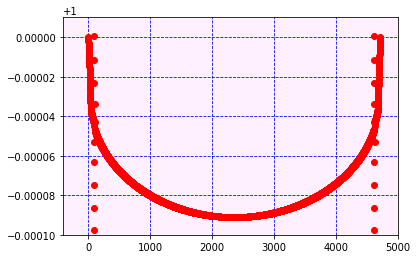

In [416]:
import matplotlib.pyplot as plt 

from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates

  

f=plt.figure()
plt.gca().set_xlim([-400,5000])
plt.gca().set_ylim([0.9999,1.00001])
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10000))

ax = plt.gca()
ax.set_facecolor((1.0, 0.94, 1))
plt.plot(index,curve,'ro')

plt.grid(True,color='blue',linestyle="--")
plt.show()

In [399]:
index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
       
        
        
# # end n cycle



# for n in range(s):
#     for t in range(np.round(t1[n]-tint),np.round(t1[n]):
#                    Jr1[n]=Jr1[n]+Jo[n,t]#

#     for t=np.round(t2[n]) to np.round(t2[n]+tint) do begin
#     Jr2[n]=Jr2[n]+Jo[n,t]#

# for n in range(s):
#     print(n,'Jr1= ',Jr1[n])#
#     print(n,'Jr2= ',Jr2[n])# 
#     Jr1[n]=Jr1[n]*5/tint#
#     Jr2[n]=Jr2[n]*5/tint#
#     J12[n]=Jr2[n]/Jr1[n]# {отношение j2[n] и j1[n]}
#     {j12[n]=j12[n]+2*delj*(Random(delt+1)-(delt+1)/2)/(delt+1)#}
#     print('J12[',n,']=',J12[n],'#')#


 

# # for n=0 to s do t1[n]=t1[n]+2*Random(delt+1)-(delt+1)#{Эта строчка и две следующие - случайные погрешности
# # for n=0 to s do t2[n]=t2[n]+2*Random(delt+1)-(delt+1)# }

    
# for n=0 to s do tav[n]=np.round((t1[n]+t2[n])/2)# {tav[n]-время середины n-того

# nn=0# for n=0 to s do nn=nn+n*n# {отсюда и до конца абзаца составление эфемериды планеты методом наименьших квадратов
# sumn=0# for n=0 to s do sumn=sumn+n# 
# ntav=0# for n=0 to s do ntav=ntav+n*tav[n]# 
# sumtav=0# for n=0 to s do sumtav=sumtav+tav[n]# 
# Delta=nn*(s+1)-sumn*sumn# 
# DeltaPp=ntav*(s+1)-sumtav*sumn# 
# Deltat0=nn*sumtav-sumn*ntav# 
# PpObs=DeltaPp/Delta# 
# t0=Deltat0/Delta# }

# print('Pp=', PpObs:9:9,' t0=',t0:6:6)# {ppObs-наблюдаемый период обращения планеты вокруг звезды, на основе известных времен транзитов в сек} 
# {t0- постоянная, входящая в эферемениду, измеряется в сек} 

# {for n=0 to s do tpl1[n]=PpObs*(n-arcnp.sin(Rs/Ap)/2/pi)#
# for n=0 to s do tpl2[n]=PpObs*(n+arcnp.sin(Rs/Ap)/2/pi)#}
# {for n=0 to s do dtt[n]=np.round(tav[n])-tef[n]# {dtt[n] - вариация времени середины n-того транзита планеты в сек
# for n=0 to s do tef[n]=np.round(n*PpObs+t0)# tef[n] - время середины n-того транзита планеты согласно эфемериде в сек} 

# for n=0 to s do dtt[n]=np.round((t1[n]-tpl1[n]+t2[n]-tpl2[n])/2)# {dtt[n] - вариация времени середины n-того транзита планеты в сек} 
# print('dtt[n]=','  ',dtt[n])#

# {for n=0 to s do print('TDV[',n,']=',-(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),'#')#}

# for n=0 to s do print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',',(1-1/J12[n])*1000000:3:3,']',',')# 

# {for n=0 to s do print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',', -(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),']',',')#}

# {for n=0 to s do print('TTV[',n,']=',trunc((t1[n]-tpl1[n]+t2[n]-tpl2[n])/2),'#')#}
# jav=0# for n=0 to s do jav=jav+j12[n]/(s+1)# print('jav=',jav:8:8)#
# dttav=0# for n=0 to s do dttav=dttav+dtt[n]/(s+1)# print('dttav=',dttav:8:4)#
# Sigmaj=0# for n=0 to s do Sigmaj=Sigmaj+j12[n]*j12[n]-jav*jav# Sigmaj=np.sqrt(Sigmaj)#
# Sigmadtt=0# for n=0 to s do Sigmadtt=Sigmadtt+dtt[n]*dtt[n]-dttav*dttav# Sigmadtt=np.sqrt(Sigmadtt)#
# Sigmajdtt=0# for n=0 to s do Sigmajdtt=Sigmajdtt+(j12[n]-jav)*(dtt[n]-dttav)# 
# print(Sigmaj,' ',Sigmadtt,' ',Sigmajdtt)# 
# Korr=Sigmajdtt/Sigmaj/Sigmadtt# 
# print('Коэффициент корреляции, Korr=', Korr:4:3)# 
# end.



In [224]:
4*np.pi/6-np.sqrt(3)/4

1.661382400500976

In [ ]:
Ω=1
print(Ω)